Project chapters:

1. Data Engineering  DONE!<br />
    a) data discovery DONE! <br />
    b) data cleanup DONE!
    
2. Data Analysis <br />
    a) data distributions DONE!<br />
    b) Rented Bike Count Fluctuations Across the Year DONE!<br />
    c) data correlations <br />
    
3. Data Science <br />
    a) Bike usage predictive model <br />
    b) feature engineering <br />
  

IDEAS <br />
* build a LR model (or other model) to predict the Rented Bike Count <br />
* predict visibility based on other weather features<br />
* check rent bike distribution per day (histogram)<br />
* Hypothesis testing: Spring time has higher mean bike rent count<br />
* analyze rented bike count fluctuations across the year<br />

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

C:\Users\Rogo\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Engineering

## Data discovery

In [3]:
#inspecting column names and data types;
bikes_df = pd.read_csv('SeoulBikeData.csv')
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [4]:
#showing first 5 rows of data
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


There are no missing values in any of the columns. Some Object data types can be adjusted for easier handling, e.g. "Date" changed into a Datetime object, "Holiday" and "Functioning Day" changed into Boolean after confirming they hold two unique values.

In [5]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [6]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [7]:
#summary of the dataset
bikes_df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [8]:
bikes_df.Date.loc[0]

'01/12/2017'

In [9]:
bikes_df.Date.loc[len(bikes_df)-1]

'30/11/2018'

The dataset includes rented bike counts from Dec 1st. 2017 to Nov. 30th 2018. The data is provided for every hour of the day, along with weather information including Temperature, Humidity, Wind Speed and Rainfall. It also describes the Season of the year for every entry and indicates whether it was a holiday or not. The bike renting service was not always available, which is described by the Functioning Day column.

The dataset consists of 8760 entries in total. The mean bike count rent is 705 rents per hour, while the median amounts to 505 rents. This difference is most likely linked to outliers with unusually high counts of bike rents. This is further reinforced by checking the min/max values for the rented bike count, which are 0 and 3556 respectively - the latter number being an example of the outlier.

The average year temperature amounts to 12.9 degrees Celsius with a median of 13.7.

An interesting observation can be made with Rainfall and Snowfall features - while they have a relatively low mean values (1.1 mm and 0.4 mm respectively), their median values are both at 0. This essentially means that over 50% of days there were no rain- or snowfalls. With that in mind, it stands to question whether these features shouldn't be boolean and signify whether it was raining or not during the given hour of a day. This might simplify any models built within this exercise without affecting their accuracy.

## Data Cleanup

Since both Holiday and Functioning Day features include only 2 unique values each, turning their data type into boolean will make further data processing more efficient. The Date feature will be turned a proper Datetime type along the way.

In [10]:
#changing Date feature into Datetime
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")

#changing Holiday feature into Boolean
bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
bikes_df.loc[bikes_df['Holiday'] == 'No Holiday', 'Holiday'] = 0
bikes_df['Holiday'] = bikes_df['Holiday'].astype(bool, copy=False)

#changing Functioning Day feature into Boolean
bikes_df.loc[bikes_df['Functioning Day'] == 'No', 'Functioning Day'] = 0
bikes_df.loc[bikes_df['Functioning Day'] == 'Yes', 'Functioning Day'] = 1
bikes_df['Functioning Day'] = bikes_df['Functioning Day'].astype(bool, copy=False)

#checking the data types after changes
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Rented Bike Count         8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   object        
 12  Holiday             

# Data Analysis

## Data distributions

To get a visual idea of the data distributions, we plotted histograms, violin plots and bar plots below for all features except for the Date, Hour, Month, Holiday and Functioning Day features.

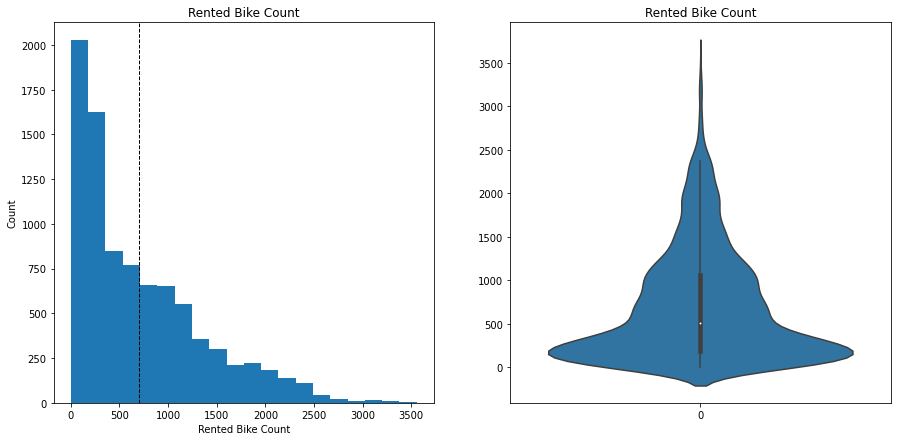

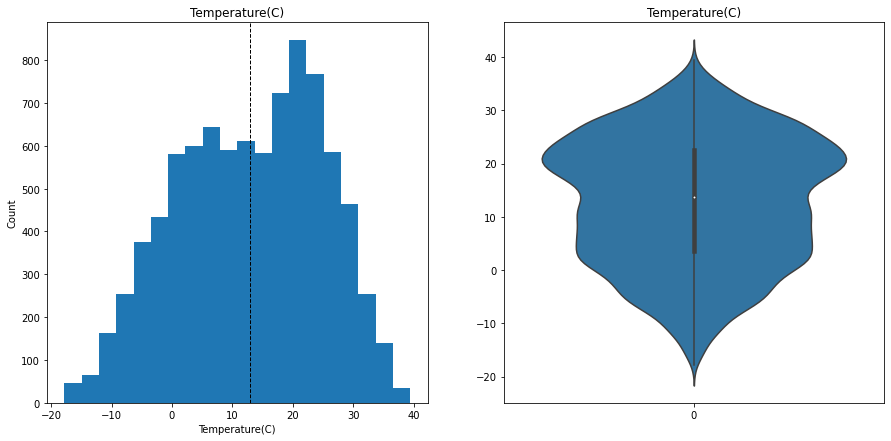

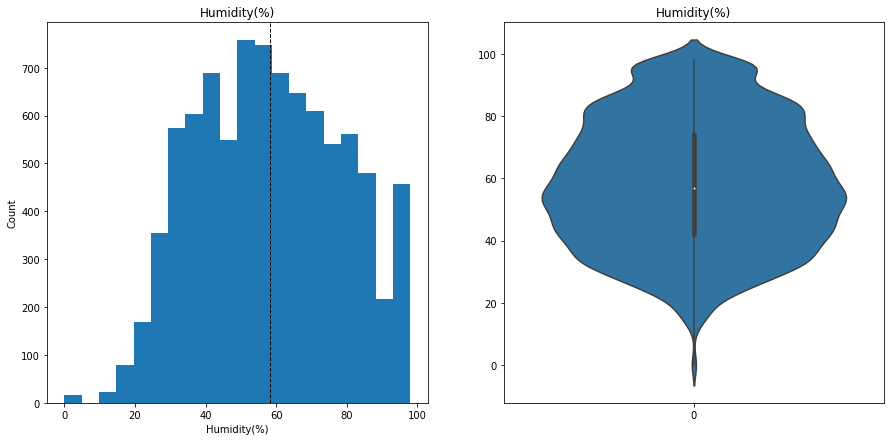

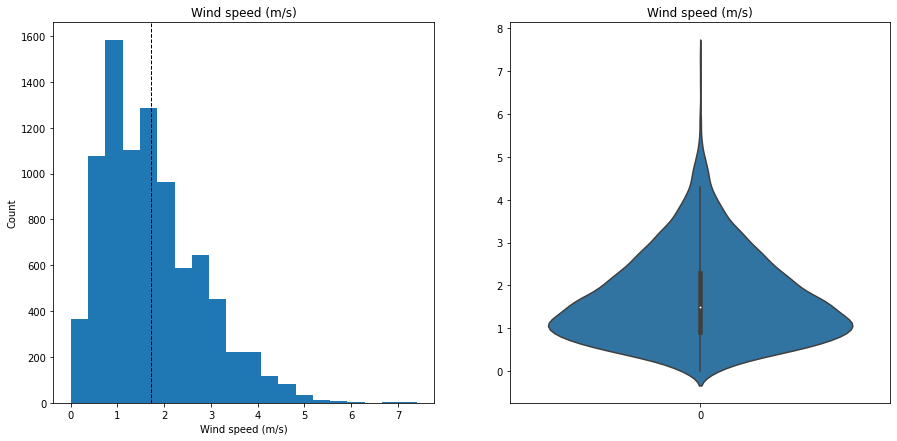

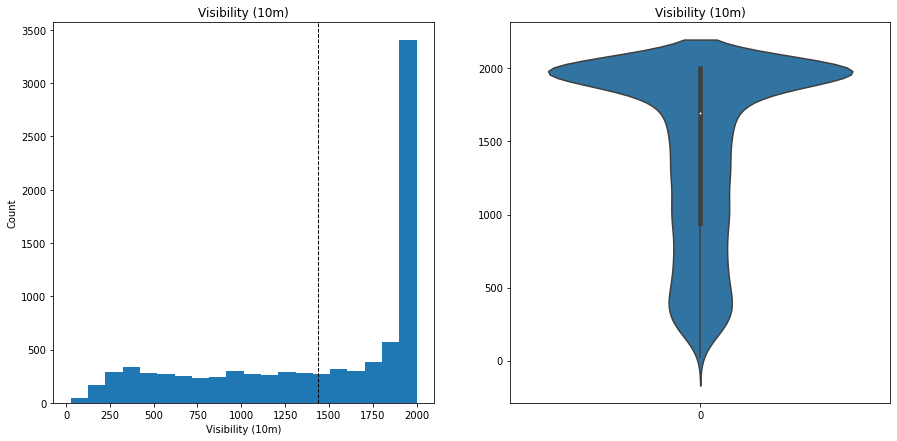

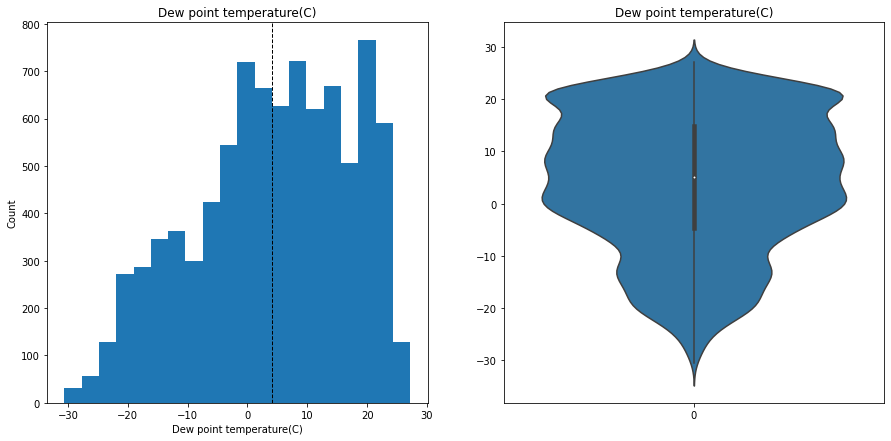

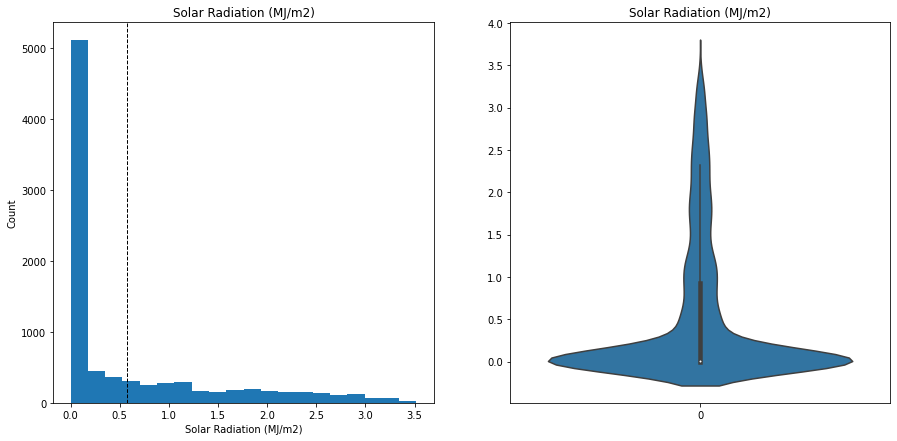

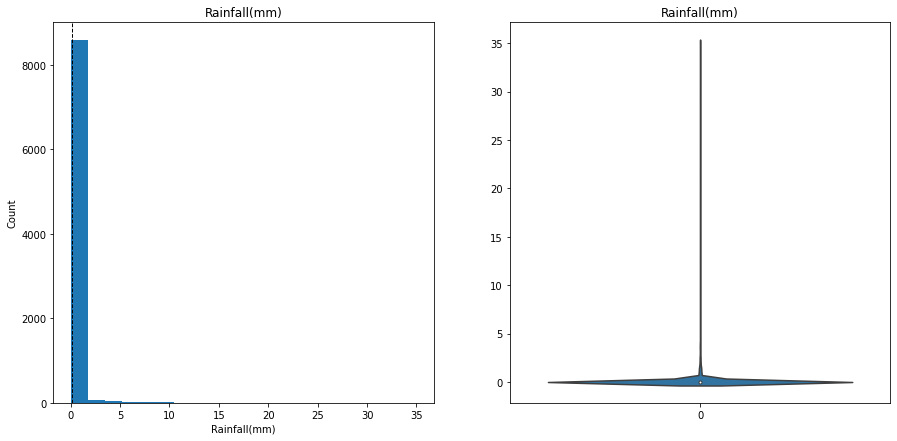

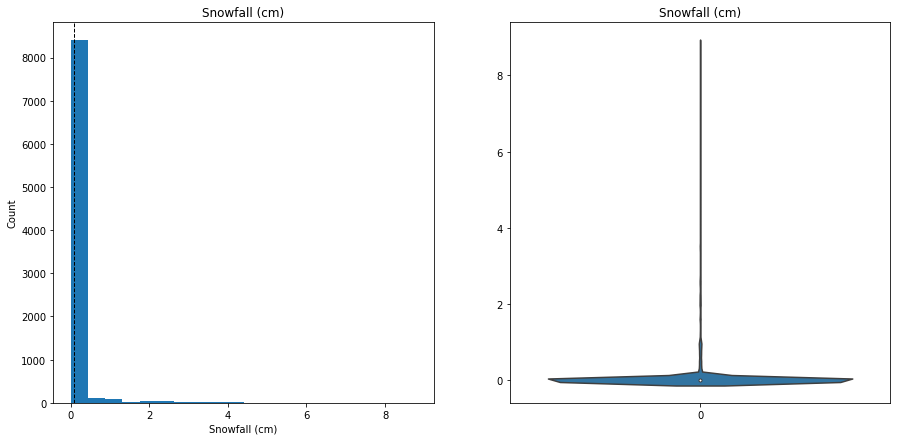

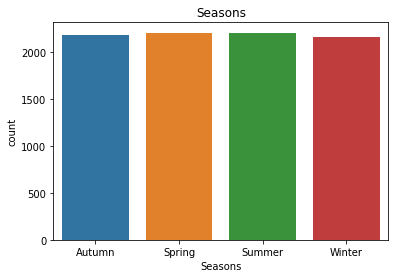

In [11]:
for i in bikes_df.columns:
    if i in ['Date', 'Hour', 'Month'] or bikes_df[i].dtype == 'bool':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,2,1)
        plt.figure
        plt.hist(bikes_df[i], bins=20)
        plt.axvline(bikes_df[i].mean(), color='k', linestyle='dashed', linewidth=1)
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        ax = plt.subplot(1,2,2)
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Rented bike count is right skewed and far from a normal distribution, as the values are concentrated around lower numbers of bike rents. The mean bike count rent per hour is around 700, while the median per hour bike rent count is around 500.<br />
Temperature is much closer to a normal distribution, although it is slightly left skewed. The mean temperature amounts to around 13 degrees Celsius, while the median is slightly higher at around 14 degrees. It is worth noting that Dew Point temperature appears to be distributed in a much similar fashion to Temperature, implying a close correlation.<br />
Humidity is normally distributed with mean humidity at 58% and the median at 57%.<br />
Wind speed, rainfall, snowfall and solar radiation are heavily right skewed, which is expected, as the high values can go to large extremes and form a long tail of outliers on the graphs. Similarly to the Visibity feature except that it is heaily left skewed.<br />
Seasons box plot is expected to show almost equal counts for all the seasons. The neglibigle differences coming from the fact that the seasons do not share the exact same number of days.




In [12]:
rent_season_group = bikes_df[['Seasons','Holiday']].groupby(['Seasons']).apply(lambda x: x['Holiday'].count() / 24).reset_index()
rent_season_group.rename(inplace=True, columns={0:'Days'})
rent_season_group

,Seasons,Days
0,Autumn,91.0
1,Spring,92.0
2,Summer,92.0
3,Winter,90.0


The rented bike count histogram presented the data as is, i.e. displayed the counts for every hour throughout the year. Let's agggregate the same data on a per day basis, to get an overview of counts distribution for entire days.

In [24]:
rent_day_group = bikes_df[['Date', 'Rented Bike Count']].groupby(['Date']).sum()
rent_day_group.head()
rent_day_group['Rented Bike Count']

Date
2017-12-01     9539
2017-12-02     8523
2017-12-03     7222
2017-12-04     8729
2017-12-05     8307
              ...  
2018-11-26    17162
2018-11-27    16282
2018-11-28    16524
2018-11-29    16423
2018-11-30    16297
Name: Rented Bike Count, Length: 365, dtype: int64

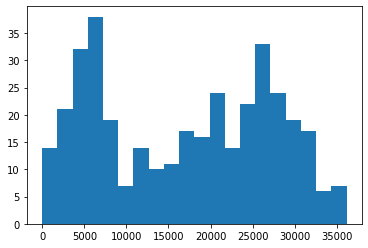

In [26]:
plt.hist(rent_day_group, bins=20)
plt.show()

The histogram has a significantly different shape then the one created for per hour bike counts. Let's see whether the shape is correlated with bike rent counts for different seasons.

## Rented Bike Count Fluctuations Across the Year

To get an overview of the bike renting service, we created a few plots below to demonstrate the trends across different months and their possible link with temperatures and rainfalls.

In [186]:
#creating the "Month" column
bikes_df['Month'] = pd.DatetimeIndex(bikes_df['Date']).month

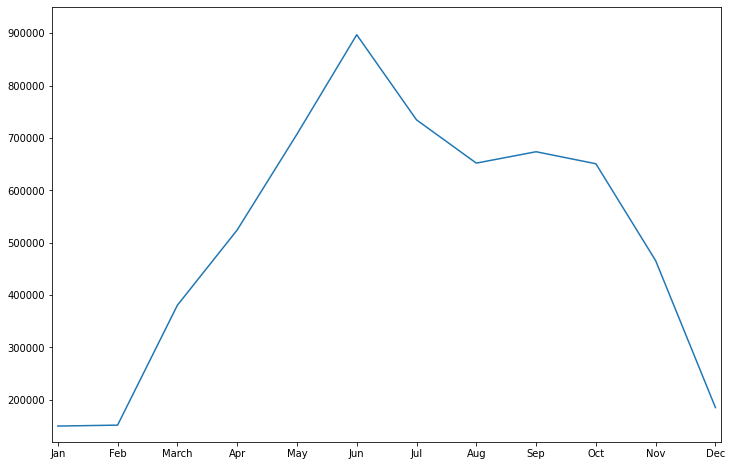

In [234]:
rent_month_group = bikes_df[['Month','Rented Bike Count']].groupby(['Month']).sum().reset_index()
months_names =['Jan', 'Feb', 'March','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_nums = range(1,13)

plt.figure(figsize=(12,8))
plt.plot(rent_month_group['Month'], rent_month_group['Rented Bike Count'])
plt.axis([0.9,12.1, 120000, 950000])
plt.xticks(month_nums, labels=months_names)

plt.show()

The total number of bike rents is the lowest in December, January and February and peaks in June. This appears to be slightly correlated by rainfall (note how the rainfall was relatively low in June compared to May and July, August) and closely correlated with the mean month temperature (see plots below).

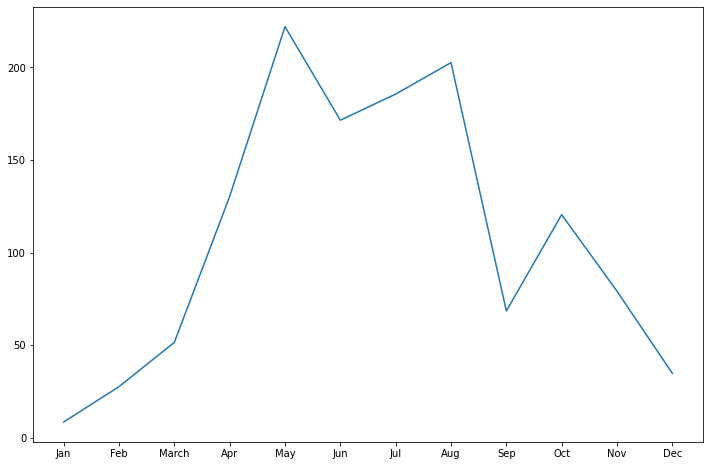

In [201]:
rainfall_month_group = bikes_df[['Month','Rainfall(mm)']].groupby(['Month']).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rainfall_month_group['Month'], rainfall_month_group['Rainfall(mm)'])
plt.xticks(month_nums, labels=months_names)
plt.show()


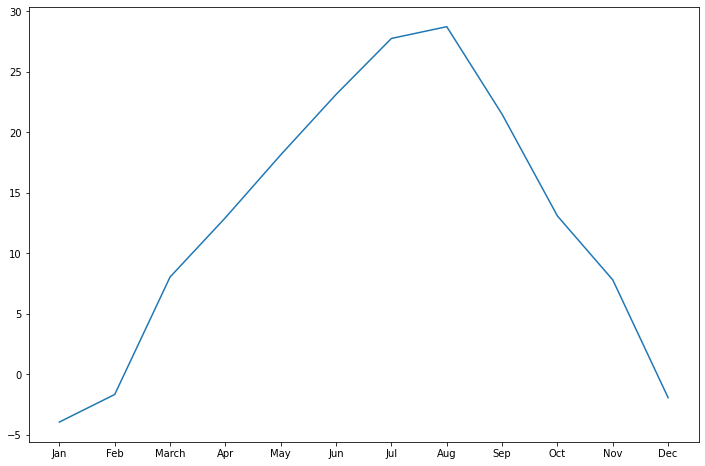

In [202]:
temperature_month_group = bikes_df[['Month','Temperature(C)']].groupby(['Month']).mean().reset_index()
plt.figure(figsize=(12,8))
plt.plot(temperature_month_group['Month'], temperature_month_group['Temperature(C)'])
plt.xticks(month_nums, labels=months_names)
plt.show()

With a relatively good understanding of the data at hand, we may proceed to analyze data correlations and see if our initial conclusions are backed by data science.

## DATA CORRELATIONS

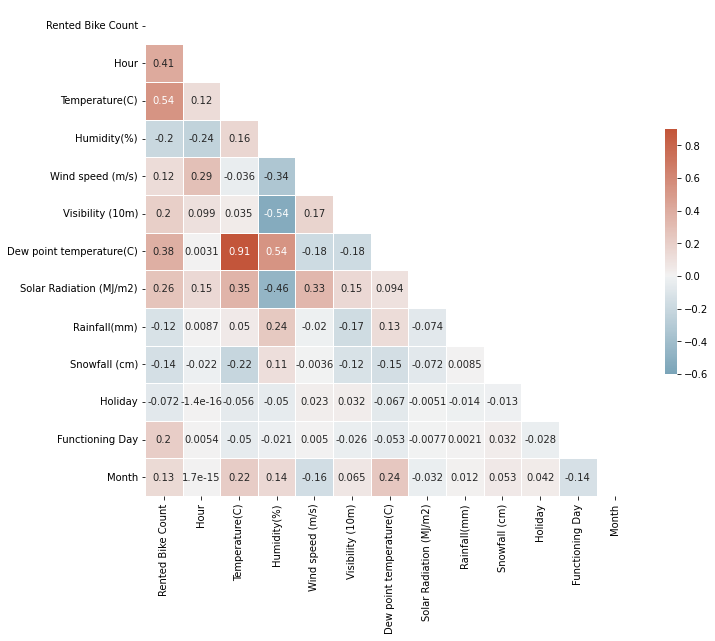

In [190]:
bikes_corr = bikes_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(bikes_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bikes_corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [191]:
frequency_table = pd.crosstab(bikes_df['Holiday'], bikes_df['Functioning Day'])
print(frequency_table)

Functioning Day  False  True
Holiday                     
False              271  8057
True                24   408


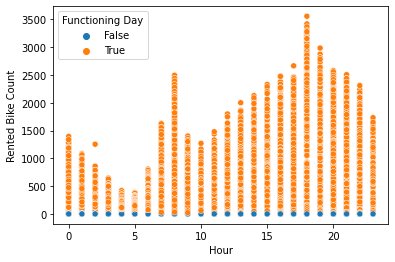

In [192]:
#plt.scatter(data=bikes_df, x='Hour', y='Rented Bike Count', alpha=0.04, hue='Functioning Day')
sns.scatterplot(y = 'Rented Bike Count', x = 'Hour', data = bikes_df, hue = 'Functioning Day')
plt.show()

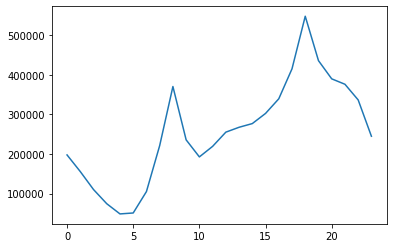

In [193]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).sum().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

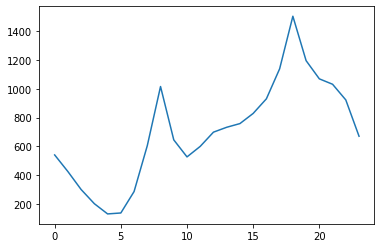

In [194]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

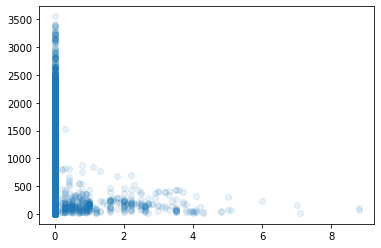

In [195]:
plt.scatter(data=bikes_df, x='Snowfall (cm)', y='Rented Bike Count', alpha = 0.1)
plt.show()

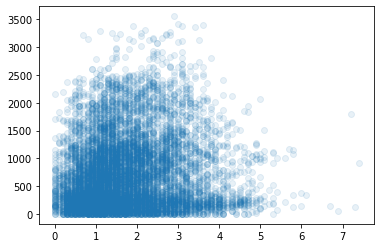

In [196]:
plt.scatter(data=bikes_df, x='Wind speed (m/s)', y='Rented Bike Count', alpha = 0.1)
plt.show()

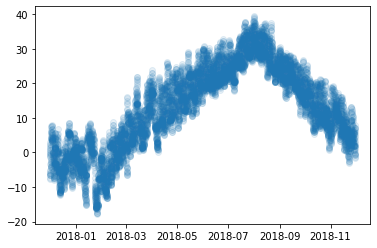

In [197]:
plt.scatter(data=bikes_df, x='Date', y='Temperature(C)', alpha = 0.1)
plt.show()

In [198]:
# dropping the data when the service was not functioning at all, as it would affect the accuracy of the model
# bikes_df = bikes_df[bikes_df['Functioning Day'] == 'Yes']
# bikes_df = bikes_df.drop(columns=['Functioning Day'])
# print(bikes_df.shape)